# Modelos de semántica distribucional

Los modelos de semántica distribucional se basan en la hipótesis distribucional que señala que dos palabras son similares si aparecen en contextos similares.

Por tanto, representan los términos a partir de observar las coocurrencias de sus contextos y crear así vectores que representen (parte de) el significado de estos términos.

In [1]:
from collections import defaultdict, Counter
from itertools import chain
from sklearn.decomposition import PCA
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Funciones de indexación

In [2]:
def vocab():
    """
    Genera un vocabulario de términ-índice.
    """
    dict = defaultdict()
    dict.default_factory = lambda: len(dict)
    return dict

def get_ids(sentences, voc):
    """
    Asigna un índice a las palabras en una oración en base a los índices del vocabulario.
    """
    for sent in sentences:
        yield [voc[w] for w in sent]

## Modelo de semántica distribucional

Definimos en primer lugar una función que nos permita obtener las coocurrencias a partir de observar una palabra objetivo y los contextos que hemos definido.

In [3]:
def get_contexts(word, contexts):
    """
    Función que obtiene coocurrencias de un término en sus contextos.
    
    Arguments
    ---------
    word : str
        Término objetivo
    contexts : list
        Lista de contextos
        
    Returns
    -------
    contexts_frec : dict
        Dictionario de coocurrencias del término
    """
    #Guarda los contextos
    neigs = []
    for context in contexts:
        #Checa si la palabra está en el contexto
        if word in context:
            #Si es así, guarda el contexto
            neigs.append(context)
    #Cuenta las palabras en contextos
    contexts_frec = Counter(list(chain(*neigs)))
    #Elimina la palabra objetivo
    contexts_frec.pop(word,0)
    
    return contexts_frec

Describimos ahora una clase que genera el modelo de semántica distribucional:

* Se genera una matriz de coocurencias $A$ definida como: $$A = (a_{i,j}) = \phi(w_i,w_j)$$ donde $\phi$ es una función de coocurrencias basada en frecuencias o PMI.
* Calcula la similitud entre térmonos en base al coseno: $$sim(w_i,w_j) = \frac{|v_i \cdot v_j|}{||v_i|| ||v_j||}$$ donde $v_i, v_j$ son los vectores distribucionales de los términos.

In [4]:
class DSModel():
    def __init__(self, func='sppmi', k=1):
        """
        La clase del modelo de semántica distribucional.
        
        Arguments
        ---------
        func : str
            Indica la función que se utilizará para obtener la matriz: 'pmi', 'ppmi' (positive pmi), 
            'spmi' (normalized pmi), 'sppmi' (normalized positive pmi)
        k = int
            Cuando se usa 'spmi' o 'sppmi' se indica el valor k del umbral.
        """
        #Función
        self.func = func
        #Valor de umbral
        self.k = k
        #Matriz de vectores
        self.A = None
        #Matriz normalizada
        self.norm_A = None
        #vocabulario de términos
        self.voc = vocab()
        
    def fit(self, sentences):
        """
        Función que crea la matriz de dsm a partir de una colección.
        
        Arguments
        ---------
        sentences : list
            Lista de contextos (por ejemplo sentencias) a partir de los cuales se harán las coocurrencias.
        """
        #Indeza los términos
        contexts = list(get_ids(sentences, self.voc))
        #obtiene las frecuencias de palabra
        frecs = Counter(list(chain(*contexts)))

        #Tamaño del vocabulario
        n = len(self.voc)
        #Crea la matriz
        self.A = np.zeros((n,n))
        for w1, i in tqdm(self.voc.items()):
            #Obntiene frecuencia de contextos de w1
            frec_cont = get_contexts(i, contexts)
            for j, f in frec_cont.items():
                #DSM por frecuencia
                if self.func == 'frec':
                    weights = f
                #DSM por PMI
                elif self.func == 'pmi':
                    weights = np.log2((f*n)/(frecs[i]*frecs[j]))
                #DSM por PMI ponderado
                elif self.func == 'spmi':
                    weights = np.log2((f*n)/(frecs[i]*frecs[j]))-np.log2(self.k)
                #DSM por PMI positivo
                elif self.func == 'ppmi':
                    weights = max(np.log2((f*n)/(frecs[i]*frecs[j])),0)
                #DSM por PMI positivo ponderado
                elif self.func == 'sppmi':
                    weights = max(np.log2((f*n)/(frecs[i]*frecs[j]))-np.log2(self.k),0)

                self.A[i,j] = weights
        
        #Normaliza la matriz para calculo de similitudes
        self.norm_A = (self.A.T/np.array([np.linalg.norm(a) for a in self.A])).T
                
    def get_vector(self, word):
        """
        Función que devuelve el vector dsm de un término.
        
        Arguments
        ---------
        word : str
            Término del que se desea obtener el vector.
            
        Returns
        -------
            Vector distribucional del término indicado.
        """
        try:
            #Regresa el vector correspondiente
            return self.A[self.voc[word]]
        except:
            #Indica si no ha visto la palabra
            print('No existe la palabra')
            
    def similarity(self, word1, word2):
        """
        Calcula la similitud coseno entre dos términos.
        
        Arguments
        ---------
        word1, word2 : str
            Términos a comparar
        
        Returns
        -------
        sim : [0,1]
            Valor de la similitud entre ambos términos.
        """
        #Obtiene los vectores de ambos términos
        v1, v2 = self.get_vector(word1), self.get_vector(word2)
        #Calcula la similitud coseno
        sim = np.abs(np.dot(v1,v2))/( np.linalg.norm(v1)*np.linalg.norm(v2) )
        
        return sim
    
    def most_similar(self, word, n=10):
        """
        Obtiene los n términos más similares dado un término objetivo.
        
        Arguments
        ---------
        word : str
            Término objetivo
        n : int
            Número de términos similares a regresar.
        
        Returns
        -------
            Lista de n términos más similares con sus similitudes.
        """
        v = self.get_vector(word)
        v_norm = v/np.linalg.norm(v)
        sims = np.abs(np.dot(self.norm_A,v_norm))
        for w,sim in sorted(zip(self.voc.keys(), sims), key=itemgetter(1), reverse=True)[:n]:
            yield w, sim

## Aplicación del modelo de DSM a un corpus

Utilizamos el corpus CESS en español que cuenta con separación en oraciones. De tal forma que aprovechamos las oraciones para que funcionen como contextos del modelo distribucional.

In [5]:
#Importa el corpus
from nltk.corpus import cess_esp

#Obtiene las oraciones del corpus
corpus = cess_esp.sents()[:500]

#Limpiamos el corpus 
#Pasando a minúsculas y
#eliminando símbolos innecesarios
sentences = []
for sent in corpus:
    clean_sent = [w.lower() for w in sent if w.lower() not in ['.',',',':','*0*','-fpt-','-fpa-','"','-']]
    sentences.append(clean_sent)
    
print(sentences[:2])

[['el', 'grupo', 'estatal', 'electricité_de_france', 'edf', 'anunció', 'hoy', 'jueves', 'la', 'compra', 'del', '51_por_ciento', 'de', 'la', 'empresa', 'mexicana', 'electricidad_águila_de_altamira', 'eaa', 'creada', 'por', 'el', 'japonés', 'mitsubishi_corporation', 'para', 'poner_en_marcha', 'una', 'central', 'de', 'gas', 'de', '495', 'megavatios'], ['una', 'portavoz', 'de', 'edf', 'explicó', 'a', 'efe', 'que', 'el', 'proyecto', 'para', 'la', 'construcción', 'de', 'altamira_2', 'al', 'norte', 'de', 'tampico', 'prevé', 'la', 'utilización', 'de', 'gas', 'natural', 'como', 'combustible', 'principal', 'en', 'una', 'central', 'de', 'ciclo', 'combinado', 'que', 'debe', 'empezar', 'a', 'funcionar', 'en', 'mayo_del_2002']]


Podemos entonces obtener el modelo de DSM a partir del corpus, tomando en cuenta las oraciones como contextos:

In [6]:
#Definimos los parámetros del modelo
dsm = DSModel(func='sppmi', k=2)
#Creamos la matriz distribucional
dsm.fit(sentences)

100%|██████████| 4420/4420 [00:02<00:00, 1671.93it/s]


In [7]:
dsm.A.shape

(4420, 4420)

In [8]:
dsm.get_vector('méxico')

array([1.05238038, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

Con este modelo podemos calcular la similitud entre dos términos:

In [9]:
dsm.similarity('democracia', 'méxico')

0.03401956584429898

Asimismo, podemos obtener los términos que más similitud compartan con un término dado:

In [10]:
for w, sim in dsm.most_similar('méxico'):
    print(w, sim)

méxico 1.0
barbados 0.5737728978078362
el_salvador 0.5737728978078362
haití 0.5737728978078362
jamaica 0.5237317193730574
honduras 0.4627291868389548
pacto_de_san_josé 0.4448002430266236
especiales 0.4448002430266236
belice 0.4448002430266236
nicaragua 0.4448002430266236


## Reducción de la dimensionalidad

Usamos una reducción de la dimensionalidad basado la descomposición en valores singulares. Es decir, tomamos como dimensiones los $k$ eigenvectores con los eigenvalores más altos para representar a los datos.

In [10]:
def svd(X, dims=2):
    """
    Función de reducción de dimensionalidad de una matriz.
    
    Arguments
    ---------
    X : array
        Matriz cuyos renglones se reducirán de dimensión
    dims : int
        Número de dimensiones finales
        
    Returns
    -------
        Vectores renglón de la matriz con dimensión dims y transformación lineal que reduce los vectores
    """
    #dimensiones de matriz original
    m,n = X.shape
    if m != n:
        X = np.dot(X.T,X)
    #Calcula la media
    mu = X.sum(0)/n
    #Normalización de los vectores
    X_norm = X-mu
    #SVD
    U, S, V = np.linalg.svd(X_norm, full_matrices=False)
    #vectores reducidos
    red_X = U[:, :dims]
    #Transformación
    T = V[:dims]
    
    return red_X, T

In [11]:
red_A,T = svd(dsm.A)

In [12]:
#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot_words(Z,ids):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

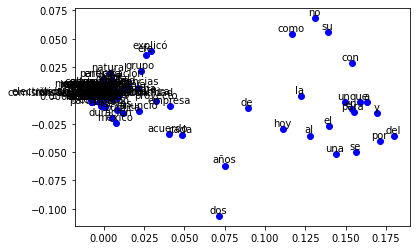

In [13]:
A = red_A[:100]
plot_words(A, list(dsm.voc.keys())[:100])

## Composicionalidad

In [11]:
def composition(w1,w2,method='sum'):
    v1, v2 = dsm.get_vector(w1), dsm.get_vector(w2)
    
    if method == 'sum':
        return v1 + v2
    elif method == 'product':
        return v1*v2
    elif method == 'avg':
        return (v1+v2)/2

In [18]:
sim = lambda x,y: np.abs(np.dot(x,y))/(np.linalg.norm(x)*np.linalg.norm(y))

sim(composition('democracia','méxico', method='sum'),composition('democracia','barbados', method='sum'))

0.8093097141288504